In [1]:
import sys
import math
from pathlib import Path
from itertools import combinations
from collections.abc import Iterable
from typing import Tuple, Union, List, Optional, Dict

import anndata as ad
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.axes import Axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set Matplotlib style
plt.style.use("../src/sg_utils/pl/assets/default.mplstyle")

# Add local source path
sys.path.insert(0, '../src')

# Import local modules
from sg_utils.pl.plot_embedding import plot_embedding, format_ax
from sg_utils.tl.get_group_markers import *
from sg_utils.tl.comparison_metrics import *
from sg_utils.config.xenium_breast import *


In [2]:
methods = ['10x_Cell', '10x_Nucleus', 'segger', 'segger_tokenized', 'Baysor' , 'BIDCell']

data_path = Path('../data/xenium_breast')
adatas_dir = data_path / 'h5ads'

scRNAseq_path = adatas_dir / 'scRNAseq.h5ad'

time_df_path = data_path / 'tables'/ 'time_analysis.csv'

In [3]:
adatas = {}
for method in methods:
    adatas[method] = sc.read(adatas_dir / f'adata_{method}.h5ad')

ads = ad.concat(adatas.values(), keys=adatas.keys(), label='params')

/Users/b450-admin/.pyenv/versions/3.10.0/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
scRNAseq_adata = sc.read(scRNAseq_path)
sc.pp.pca(scRNAseq_adata)
sc.pp.neighbors(scRNAseq_adata)
sc.tl.umap(scRNAseq_adata)
# find markers
markers = find_markers(scRNAseq_adata, cell_type_column="celltype_major", pos_percentile=30, neg_percentile=5)
# Find mutually exclusive genes based on scRNAseq data
exclusive_gene_pairs = find_mutually_exclusive_genes(
    adata=scRNAseq_adata, markers=markers, cell_type_column="celltype_major"
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
len(exclusive_gene_pairs)

236

In [6]:
# Compute MECR for each segmentation method
mecr_results = {}
for method in adatas.keys():
    mecr_results[method] = compute_MECR(adatas[method], exclusive_gene_pairs)
    
mecr_data = []
for method, mecr_results in mecr_results.items():
    for gene_pair, mecr_value in mecr_results.items():
        mecr_data.append(
            {"Segmentation Method": method, "Gene Pair": f"{gene_pair[0]} - {gene_pair[1]}", "MECR": mecr_value}
        )
mecr_df = pd.DataFrame(mecr_data)
    

In [10]:
method_colors = {
    "segger": "#C72228",
    "segger+": "#E69F00",
    "segger++": "#F0E442",
    "segger_tokenized": "#E69F00",
    "segger (nucleus+)": '#f48365',
    "segger (nucleus-)": '#E69F00',
    "segger_fragments": '#E69F00',
    "Baysor": "#72A8E6",
    "Baysor (nucleus+)": "#0F4A9C",
    "Baysor (nucleus-)": "#0072B2",
    "10x_Cell": "#BB8BEB",
    "10x_Nucleus": "#F46CB7",
    'BIDCell': '#CDF3AF'
}

In [7]:
mecr_df

Segmentation Method       Gene Pair      MECR
0               10x_Cell     MMRN2 - DPT  0.044381
1               10x_Cell    MMRN2 - IGF1  0.059426
2               10x_Cell   CLEC14A - DPT  0.060414
3               10x_Cell  CLEC14A - IGF1  0.081187
4               10x_Cell      AQP1 - DPT  0.133555
...                  ...             ...       ...
1411             BIDCell    C1QC - DERL3  0.025146
1412             BIDCell    AIF1 - DERL3  0.031543
1413             BIDCell     CD4 - DERL3  0.029780
1414             BIDCell   KRT14 - DERL3  0.018137
1415             BIDCell    KRT5 - DERL3  0.023446

[1416 rows x 3 columns]

In [11]:
adatas['BIDCell'].X = adatas['BIDCell'].X.toarray()

In [12]:
purified_markers = find_markers(scRNAseq_adata, "celltype_major", neg_percentile=10, percentage=50, pos_percentile=90)

sensitivity_results_per_method = {}
for method, adata in adatas.items():
    sensitivity_results = calculate_sensitivity(adata, purified_markers, max_cells_per_type=2000)
    sensitivity_results_per_method[method] = sensitivity_results

# Prepare data for sensitivity boxplots
sensitivity_boxplot_data = []
for method, sensitivity_results in sensitivity_results_per_method.items():
    for cell_type, sensitivities in sensitivity_results.items():
        method_df = pd.DataFrame({"Cell Type": cell_type, "Sensitivity": sensitivities, "Segmentation Method": method})
        sensitivity_boxplot_data.append(method_df)

# Concatenate all sensitivity dataframes into one
sensitivity_boxplot_data = pd.concat(sensitivity_boxplot_data)

In [13]:
sensitivity_boxplot_data

Cell Type  Sensitivity Segmentation Method
0           Endothelial     0.116903            10x_Cell
1           Endothelial     0.148910            10x_Cell
2           Endothelial     0.120161            10x_Cell
3           Endothelial     0.129969            10x_Cell
4           Endothelial     0.195676            10x_Cell
...                 ...          ...                 ...
1995  Cancer Epithelial     0.451247             BIDCell
1996  Cancer Epithelial     0.308369             BIDCell
1997  Cancer Epithelial     0.418431             BIDCell
1998  Cancer Epithelial     0.288531             BIDCell
1999  Cancer Epithelial     0.309889             BIDCell

[107766 rows x 3 columns]

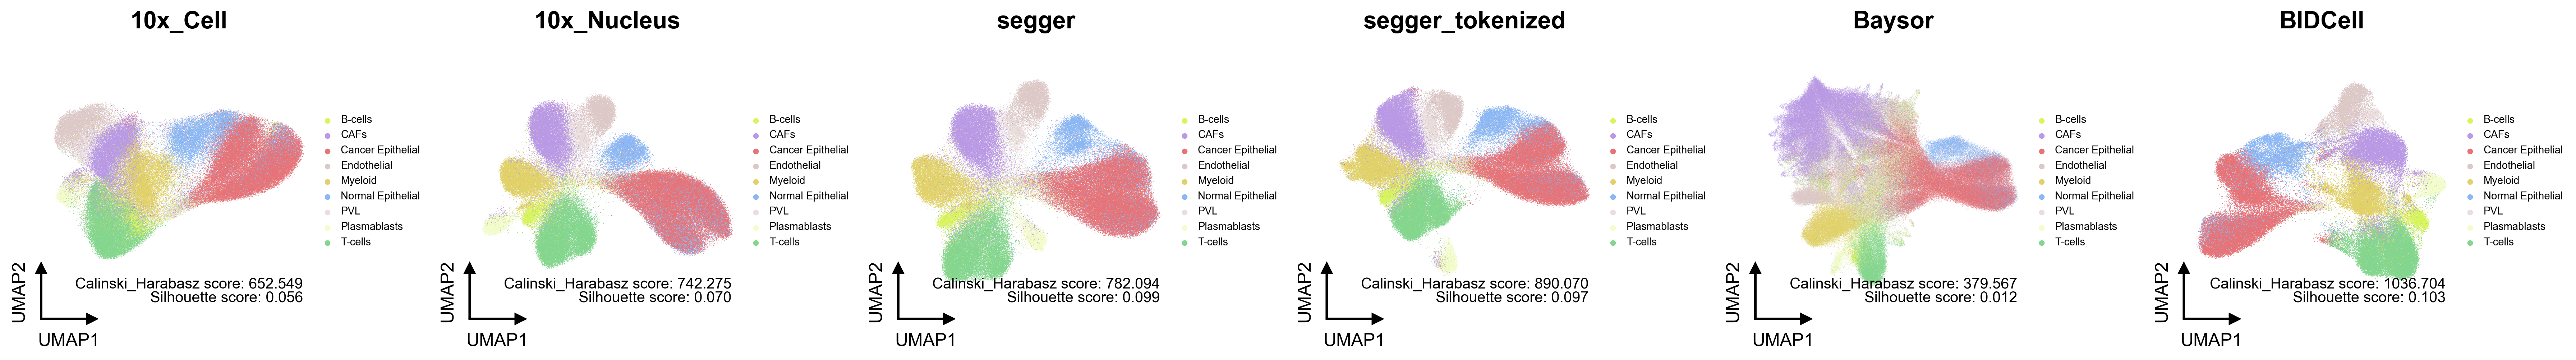

In [9]:
labels = methods
# labels.sort()

# Create a 2x3 grid plot (2 rows, 3 columns)
fig, axes = plt.subplots(1, 6, figsize=(24, 4))
axes = axes.flatten()

# Iterate through datasets and axes
for i, (ax, key) in enumerate(zip(axes, labels)):  # Exclude the last cell for legend
    adata = adatas[key]
    
    # Compute clustering scores
    ch_score, sh_score = compute_clustering_scores(adata, cell_type_column='celltype_major', use_pca=True)
    
    # Plot embeddings
    plot_embedding(
        adata,
        features='celltype_major',
        basis="X_umap",
        palette=major_colors,
        ax=ax,
        dim_label="UMAP",
        fs=12,
        lw=1.5,
        arrow_len=0.2,
        draw_arrows=True,
        # legend=False
        # cbar=False,  # Turn off colorbar for all subplots
    )
    ax.set_title(key, weight="bold", fontsize=16, pad=10)
    
    # Add scores to the plot
    ax.text(
        0.95, 0.05, 
        f"Silhouette score: {sh_score:.3f}",
        transform=ax.transAxes,
        fontsize=10,
        color="black",
        ha="right",
        va="bottom",
    )
    
    ax.text(
        0.95, 0.1, 
        f"Calinski_Harabasz score: {ch_score:.3f}",
        transform=ax.transAxes,
        fontsize=10,
        color="black",
        ha="right",
        va="bottom",
    )

# Add legend only to the last subplot
# legend_ax = axes[-1]
# legend_ax.axis("off")  # Turn off the axis

# # Create a manual legend based on the palette
# legend_patches = [
#     mpatches.Patch(color=color, label=label) for label, color in major_colors.items()
# ]

# # Add the legend to the last axis, centered
# legend_ax.legend(
#     handles=legend_patches,e
#     loc="center",
#     fontsize=12,
#     frameon=False,
# )

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


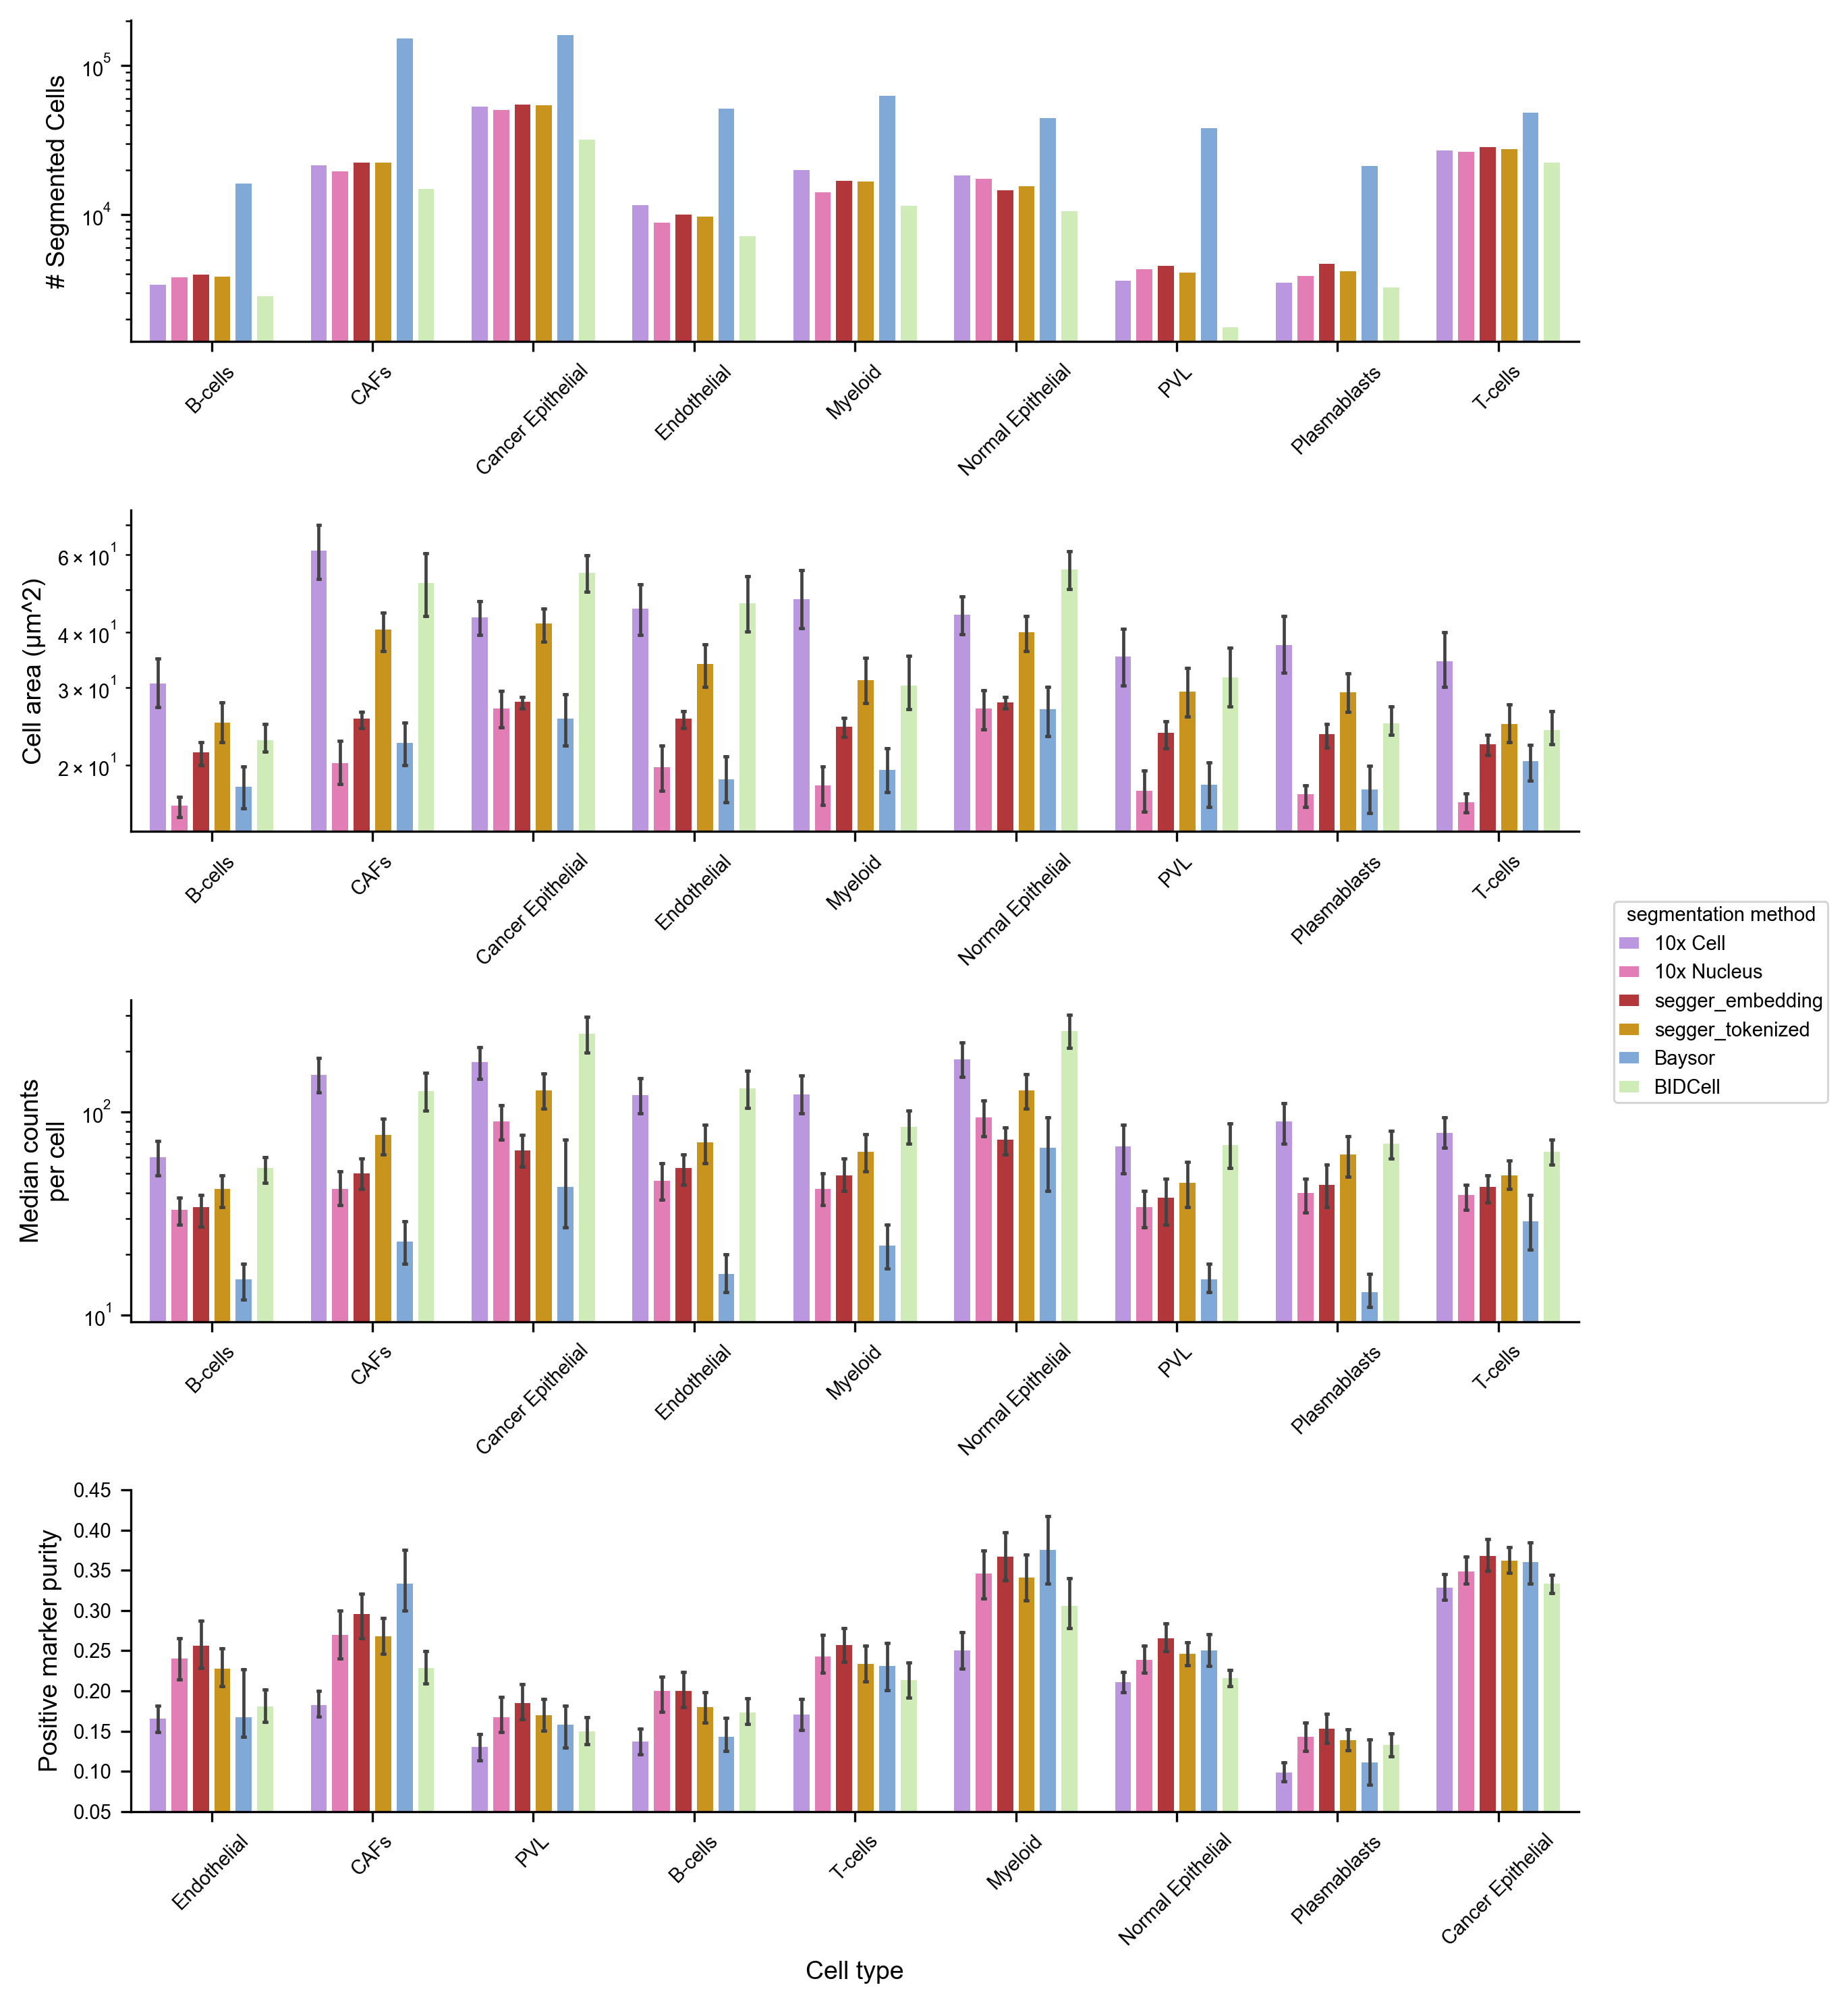

In [21]:
fig, axs = plt.subplots(4,1, figsize=(8,10))
import anndata as ad

axs = axs.flat
# ads = ad.concat(adatas_processed, keys=adatas_processed.keys)

sns.countplot(
    ads.obs, x="celltype_major", hue='params',
    # bins=50,
    # hue_order=order,
    palette=method_colors,
    ax=axs[0],
        gap=.25,
)
axs[0].set_ylabel('# Segmented Cells')
# ax.set_xticks(rotation=70, rotation_mode='anchor')
axs[0].set_xlabel('')
axs[0].set_yscale('log')
axs[0].tick_params(axis='x', rotation=45)


sns.barplot(
    ads.obs, x="celltype_major", y="cell_area", hue='params',
    # bins=50,
    capsize=.1,
    errorbar=('pi', 25),
    palette=method_colors,
    estimator=np.median,
        gap=.25,
    # hue_order=order,
    ax=axs[1],
)
axs[1].set_ylabel(u'Cell area (\u03bcm^2)')
# ax.set_xticks(rotation=70, rotation_mode='anchor')
axs[1].set_yscale('log')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', rotation=45)


sns.barplot(
    ads.obs, x="celltype_major", y="transcripts", hue='params', 
    # bins=50,
    capsize=.1,
    errorbar=('pi', 25),
    estimator=np.median,
    palette=method_colors,
        gap=.25,
    # hue_order=order,
    ax=axs[2],
)
axs[2].set_ylabel(u'Median counts\nper cell')
# ax.set_xticks(rotation=70, rotation_mode='anchor')
axs[2].set_xlabel('')
axs[2].set_yscale('log')
axs[2].tick_params(axis='x', rotation=45)


sns.barplot(
    sensitivity_boxplot_data, x="Cell Type", y="Sensitivity", hue='Segmentation Method', 
    # bins=50,
    capsize=.1,
    errorbar=('pi', 25),
    estimator=np.median,
    palette=method_colors,
        gap=.25,
    # hue_order=order,
    ax=axs[3],
)
axs[3].set_ylabel('Positive marker purity')
axs[3].set(ylim=(0.05, .45))
# ax.set_xticks(rotation=70, rotation_mode='anchor')
axs[3].set_xlabel('Cell type')
# axs[3].set_yscale('log')
axs[3].tick_params(axis='x', rotation=45)

# -------------------------
# 1) Extract handles & labels from one subplot (all should match the same hue)
handles, labels = axs[0].get_legend_handles_labels()

method_names = {
    'segger': 'segger_embedding', 
    'segger_tokenized': 'segger_tokenized',
    'baysor': 'Baysor', 
    'Baysor': 'Baysor', 
    'BIDCell': 'BIDCell',
    '10x_Cell': '10x Cell', 
    '10x_Nucleus': '10x Nucleus'
}

labels = [method_names[label] for label in labels]

# 2) Remove each subplot's legend entirely
for ax in axs:
    if ax.get_legend():
        ax.get_legend().remove()

# 3) Create a single legend for the whole figure, on the right
fig.legend(
    handles, labels, 
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),  # shift legend to the right
    title="segmentation method"
)

# Make space on the right so the legend isn’t cut off
plt.subplots_adjust(hspace=2, top=0.8)
plt.savefig('../results/metrics_celltype.pdf', bbox_inches='tight')
fig.tight_layout()
plt.show()

/var/folders/5x/ypt5v1fx6rs06gz37q_85t900000gp/T/ipykernel_45879/807965937.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels, rotation=45, ha='right')
/var/folders/5x/ypt5v1fx6rs06gz37q_85t900000gp/T/ipykernel_45879/807965937.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels, rotation=45, ha='right')
/var/folders/5x/ypt5v1fx6rs06gz37q_85t900000gp/T/ipykernel_45879/807965937.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(labels, rotation=45, ha='right')
/var/folders/5x/ypt5v1fx6rs06gz37q_85t900000gp/T/ipykernel_45879/807965937.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a 

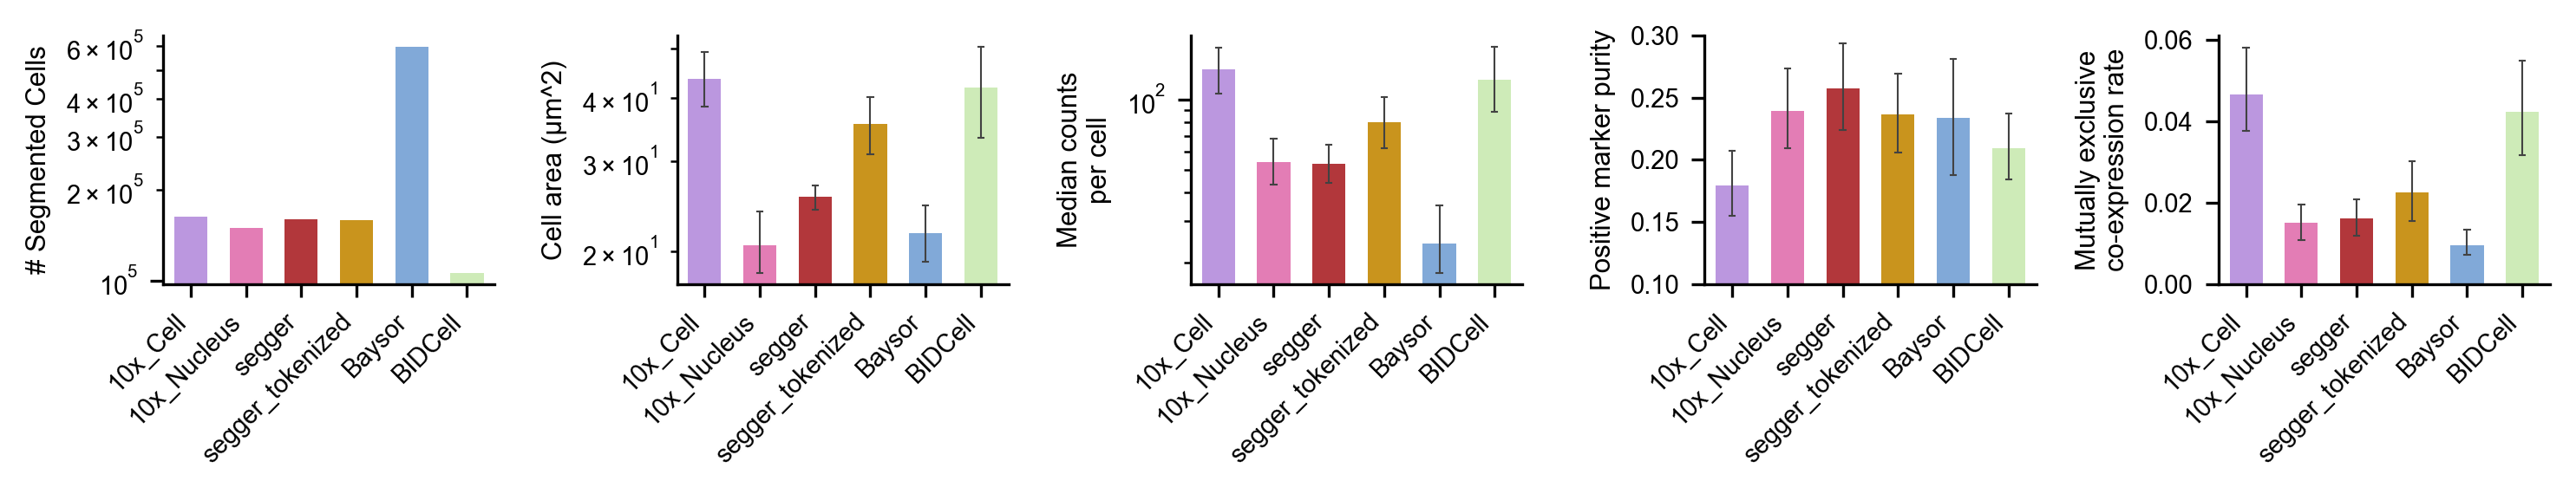

In [18]:
fig, axs = plt.subplots(1,5, figsize=(10,2))
import anndata as ad

axs = axs.flat
# labels = adata.keys()
# ads = ad.concat(adatas_processed, keys=adatas_processed.keys)

sns.countplot(
    ads.obs, x="params", hue='params',
    # bins=50,
    # hue_order=order,
    palette=method_colors,
    ax=axs[0],
    gap=.25
)
axs[0].set_ylabel('# Segmented Cells', fontsize=7.5)
# ax.set_xticks(rotation=70, rotation_mode='anchor')
axs[0].set_xlabel('')
axs[0].set_yscale('log')
axs[0].set_xticklabels(labels, rotation=45, ha='right')




sns.barplot(
    ads.obs, x="params", y="cell_area", hue='params',
    # bins=50,
    capsize=.1,
    errorbar=('pi', 25),
    palette=method_colors,
    estimator=np.median,
    # hue_order=order,
    ax=axs[1],
    gap=.25,
    err_kws={"linewidth": .5}
)
axs[1].set_ylabel(u'Cell area (\u03bcm^2)', fontsize=7.5)
# ax.set_xticks(rotation=70, rotation_mode='anchor')
axs[1].set_yscale('log')
axs[1].set_xlabel('')
axs[1].set_xticklabels(labels, rotation=45, ha='right')
# axs[1].set(ylim=(0, 75))

sns.barplot(
    ads.obs, x="params", y="transcripts", hue='params', 
    # bins=50,
    capsize=.1,
    errorbar=('pi', 25),
    estimator=np.median,
    palette=method_colors,
    # hue_order=order,
    ax=axs[2],
    gap=.25,
    err_kws={"linewidth": .5}
)
axs[2].set_ylabel(u'Median counts\nper cell', fontsize=7.5)
# ax.set_xticks(rotation=70, rotation_mode='anchor')
axs[2].set_xlabel('')
axs[2].set_yscale('log')
axs[2].set_xticklabels(labels, rotation=45, ha='right')
# axs[2].set(ylim=(0, 1000))


sns.barplot(
    sensitivity_boxplot_data, x="Segmentation Method", y="Sensitivity", hue='Segmentation Method', 
    # bins=50,
    capsize=.1,
    errorbar=('pi', 25),
    estimator=np.median,
    palette=method_colors,
    # hue_order=order,
    ax=axs[3],
    gap=.25,
    err_kws={"linewidth": .5}
)
axs[3].set_ylabel('Positive marker purity', fontsize=7.5)

axs[3].set(ylim=(.1, .3))
# ax.set_xticks(rotation=70, rotation_mode='anchor')
axs[3].set_xlabel('')
# axs[3].set_yscale('log')
axs[3].set_xticklabels(labels, rotation=45, ha='right')


sns.barplot(
    mecr_df, x="Segmentation Method", y="MECR", hue='Segmentation Method', 
    # bins=50,
    capsize=.1,
    errorbar=('pi', 25),
    estimator=np.median,
    palette=method_colors,
    # hue_order=order,
    ax=axs[4],
    gap=.25,
    err_kws={"linewidth": .5}
)
axs[4].set_ylabel(u'Mutually exclusive\nco-expression rate', fontsize=7.5)
# ax.set_xticks(rotation=70, rotation_mode='anchor')
axs[4].set_xlabel('')
# axs[4].set_yscale('log')
axs[4].set_xticklabels(labels, rotation=45, ha='right')


# # -------------------------
# # 1) Extract handles & labels from one subplot (all should match the same hue)
# handles, labels2 = axs[0].get_legend_handles_labels()

# # 2) Remove each subplot's legend entirely
# for ax in axs:
#     if ax.get_legend():
#         ax.get_legend().remove()

# # 3) Create a single legend for the whole figure, on the right
# fig.legend(
#     handles, labels2, 
#     loc='center left',
#     bbox_to_anchor=(1.0, 0.5),  # shift legend to the right
#     title="segmentation method"
# )

# Make space on the right so the legend isn’t cut off
plt.subplots_adjust(right=0.8)

fig.tight_layout()
plt.show()